# Tutorial: Causal Mediation Analysis with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. 

This tutorial contains a number of examples introducing the use of the implemented mediation functionality and a "technical appendix" for more detailed setups.

__Note:__ This implementation explicitely addresses not only time series, but also non-time series data.

## Introduction and Contents

Mediation analysis aims to understand the relative importance of different pathways and interactions in a graph.
This tutorial serves both to illustrate the potential use-cases of causal mediation-analysis in general
and through the implementation provided within the tigramite-package in particular.
The tutorial is mostly based on demonstrating the use of the implementation and the analysis of qualitatively
different effects in a number of simple yet informative examples.

Counterfactual mediation results \[1,2,3\] can be very powerfull, but often much care should be taken in their interpretation. If possible, we recommend evaluating on toy-models to what degree certain phenomena are captured qualitatively or quantitatively (see Example 5).

The implementation given here relies on adjustment-sets (combining \[3\] with, \[4,5\] for automatically generating candidate-sets). There are other methods of estimating mediation-effects (see e.g. \[6,7\] as a starting point) and were possible, validating different methods against each other seems important
and recommendable.
Counterfactual effect-estimation might require "out-of-context" falsification (e.g. through expert-knowledge), see for example \[8\].

The default (function-level) fits used are mainly used for performance and interpretability reasons. Oftentimes there will be more suitable regressors for given data. To account for this, (function-level) fits can easily be replaced by other regressors (see appendix B).

### The examples are:
* [Example 0](#ex0): Direct starting point from the "Causal Effects" tutorial.\
    (a) Syntax and Overview\
    (b) Handling Missing Data

Qualitative phenomena that are detectable (on a three-node "triangle" graph):
* [Example 1](#ex1): Effect-Moderation.
* [Example 2](#ex2): Effect on categorical Variables as shift in distribution.
* [Example 3](#ex3): Saturation of Pathways passing through Categorical Variables.

Graph-effects and time-series data:
* [Example 4](#ex4): Simple "feedback-loop" system.
* [Example 5](#ex5): A "full-stack" (causal discovery to interpreting mediation results) example.
* [Example 6](#ex6): Unidentified effects.

### The 'technical appendix' contains:
* [A](#exA): Evaluate estimator performance on ensembles of toy-models.
* [B](#exB): Extension-points for using different (function-)fit implementations.
* [C](#exC): Inspecting fits and some pitfalls.

### References:  
\[1\] J. M. Robins and S. Greenland. Identifiability and exchangeability for direct and indirect effects. Epidemiology, 3(2):143–155, 1992.  
\[2\] J. Pearl. Direct and indirect effects. Proceedings of the Seventeenth Conference on Uncertainty in Artificial intelligence, 2001.  
\[3\] I. Shpitser and T. J. VanderWeele. A complete graphical criterion for the adjustment formula in mediation analysis. The international journal of biostatistics, 7(1), 2011.   
\[4\] E. Perkovic, J. Textor, M. Kalisch, and M. H. Maathuis. Complete graphical characterization and construction of adjustment sets in markov equivalence classes of ancestral graphs. 2018.  
\[5\] J. Runge. Necessary and sufficient graphical conditions for optimal adjustment sets in causal graphical models with hidden variables. Advances in Neural Information Processing Systems, 34:15762–15773, 2021.  
\[6\] J. Pearl. Interpretation and identification of causal mediation. Psychological methods, 19(4):459, 2014.  
\[7\] I. Shpitser. Counterfactual graphical models for longitudinal mediation analysis with unobserved confounding. Cognitive science, 37(6):1011–1035, 2013.  
\[8\] J. M. Robins and T. S. Richardson. Alternative graphical causal models and the identification of direct effects. Causality and psychopathology: Finding the determinants of disorders and their cures, 84:103–58, 2010.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tigramite import plotting as tp
from tigramite.causal_effects import CausalEffects

# Data and groundtruth generation from non-additive toymodels:
import tigramite.toymodels.non_additive as toy_setup
from tigramite.toymodels.non_additive import ContinuousVariable, CategoricalVariable, Environment, Model, World, PlotInfo

# Standalone or direct use with tigramite via toy_setup.VariablesFromDataframe or toy_setup.DataframeFromVariables:
import tigramite.causal_mediation as mediation

# Extending tigramite's CausalEffects (see Example 0):
from tigramite.causal_mediation import CausalMediation

# Example 0: Direct use with Tigramite <a id='ex0'></a>
The mediation analysis can be used directly with tigramite data-types or with shorthands provided by the
non-additive toymodel-implementation, see also Example 5 for easy-to-use data conversions.
Use with tigramite enables the use of data-frame based proprocessing features like missing data (see part b below).

## (a) Syntax and Overview

The following example is taken from the "Effect Estimation" tutorial, see section 'Causal effects in time series DAGs' there for details.
The only modification required is to replace 'CausalEffects' by 'CausalMediation' (which extends the former).

Note, that when using many continuous variables, depending on the fit-mechanism used (here nearest neighbor) it might be important to normalize data to get reasonable results. This applies (of course) in particular, if scales are different. For example setting the direct_effect to a huge value (e.g. 500) will completely invalidate the multi-dimensional nearest-neighbor fit: 'Nearest' in the isotropic n-dimensional space is then essentially the same as nearest in the (lagged) values of $X^2$.


##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(1, -2)]
Y = [(2, 0)]
S = []
M = [(1, 0), (2, -1), (2, -2), (1, -1)]



Oset =  [('$X^2$', -3), ('$X^1$', -4), ('$X^1$', -3)]


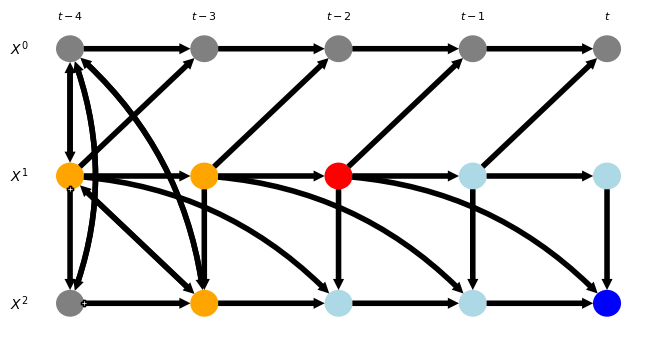

In [2]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
#causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y,
#                               S=None, 
#                               hidden_variables=None, 
#                               verbosity=1)
causal_effects = CausalMediation(graph, graph_type='stationary_dag', X=X, Y=Y,
                                S=None, # (currently S must be None)
                                hidden_variables=None, # (currently hidden must be None)
                                verbosity=1)
var_names = ['$X^0$', '$X^1$', '$X^2$']

opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

    
tp.plot_time_series_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        special_nodes=special_nodes
        ); plt.show()

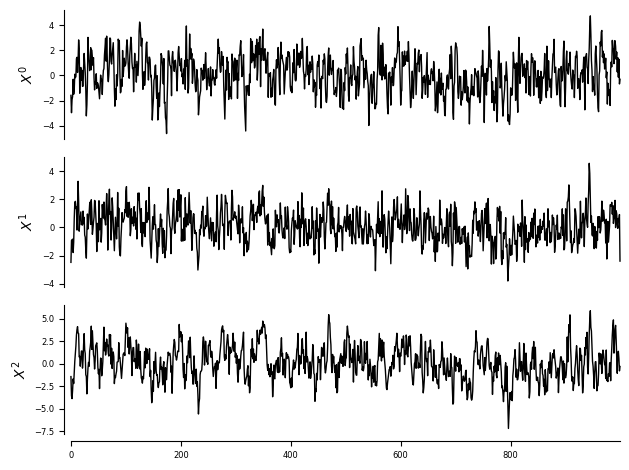

In [3]:
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

coeff = .5
direct_eff = 0.5
def lin_f(x): return x
links_coeffs = {
                0: [((0, -1), coeff, lin_f), ((1, -1), coeff, lin_f)], 
                1: [((1, -1), coeff, lin_f),], 
                2: [((2, -1), coeff, lin_f), ((1, 0), coeff, lin_f), ((1,-2), direct_eff, lin_f)],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=None)
normalization = []
data_normalized = np.empty_like(data)
for v in range(0,3):
    m = np.std(data[:,v])
    normalization.append(m)
    data_normalized[:,v] = data[:,v] / m
dataframe = pp.DataFrame(data, var_names=var_names)
dataframe_normalized = pp.DataFrame(data_normalized, var_names=var_names)

tp.plot_timeseries(dataframe); plt.show()

In [4]:
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))

# unnormalized data
causal_effects.fit_natural_direct_effect(dataframe, blocked_mediators='all',
                                mixed_data_estimator=fit_setup).PrintInfo()

nde_est = causal_effects.predict_natural_direct_effect(0.0, 1.0)

# normalized data
causal_effects.fit_natural_direct_effect(dataframe_normalized, blocked_mediators='all',
                                mixed_data_estimator=fit_setup,
                                enable_dataframe_based_preprocessing=False)

nde_est_from_normalized = causal_effects.predict_natural_direct_effect(0.0, 1.0) * normalization[2] / normalization[1]

# print results
print( f"Estimate of the NDE is:\n{nde_est} from unnormalized data, "
     + f"\n{nde_est_from_normalized} from normalized data,\nground-truth is {direct_eff}." )

Estimator for the effect of Source[$X^1$ at lag -2] on Target[$X^2$ at lag 0]
Blocked Mediators:
 - Mediator[$X^1$ at lag 0]
 - Mediator[$X^2$ at lag -1]
 - Mediator[$X^2$ at lag -2]
 - Mediator[$X^1$ at lag -1]
Adjustment Set:
 - Adjustment[$X^2$ at lag -3]
 - Adjustment[$X^1$ at lag -4]
 - Adjustment[$X^1$ at lag -3]
Estimate of the NDE is:
0.25831881165504456 from unnormalized data, 
0.3181540369987488 from normalized data,
ground-truth is 0.5.


While normalization helps (especially with large scale-differences), for large adjustment and mediator sets  high-dimensional fits are required, and nearest neighbor regressors seem to be of only limited use.

## (b) Data Preprocessing for Missing-Data

The tigramite::dataframe class provides a number of preprocessing-features, which are accessible directly via the CausalMediation interface,
by setting `enable_dataframe_based_preprocessing=True` (default) when fitting the effect (see below).
We demonstrate this here for a problem with missing data.

This reuses the data gernerated by part (a), run code there to initialize data.
We then insert (or rather: remove) samples to similate missing data.

In principle handling missing data "late" (i.\,e.\  in the fitter) can be more sample-efficient, see appendix B. However it requires partial reimplementation (for missing-data, see appendix B.6) of some features of the data-frame by the user, so the `enable_dataframe_based_preprocessing=True` option can often greatly facilitate usage at often negligibly low cost in efficiency.

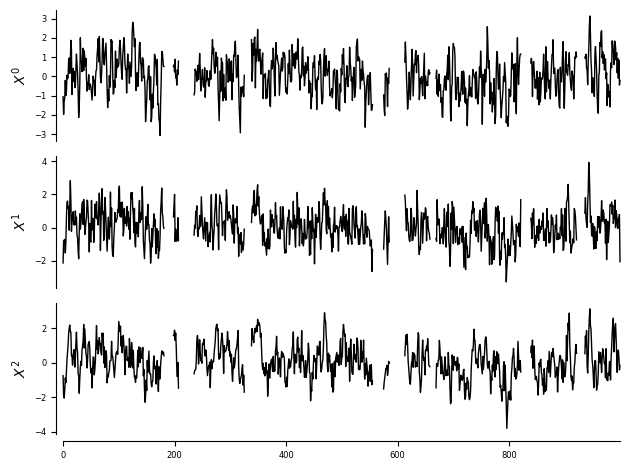

In [5]:
seed = 12345
gap_count = 10
gap_min_len = 10
gap_max_len = 20
rng = np.random.default_rng(seed)
var_idx = rng.integers(0, data_normalized.shape[1], gap_count)
offset = rng.integers(0, data_normalized.shape[0]-gap_max_len, gap_count)
missing_count = rng.integers(10, 20, gap_count)

modified_data = data_normalized
for gap in range(gap_count):
    modified_data[offset[gap]:offset[gap]+missing_count[gap], var_idx] = 999

dataframe_missing_data = pp.DataFrame(data_normalized, var_names=var_names, missing_flag=999)
tp.plot_timeseries(dataframe=dataframe_missing_data); plt.show()

In [6]:
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))

# normalized data
causal_effects.fit_natural_direct_effect(dataframe_missing_data, blocked_mediators='all',
                                mixed_data_estimator=fit_setup,
                                enable_dataframe_based_preprocessing=True)

nde_est = causal_effects.predict_natural_direct_effect(0.0, 1.0) * normalization[2] / normalization[1]

# print results
print( f"Estimate of the NDE is:\n{nde_est} with missing values,\nground-truth is {direct_eff}." )

Estimate of the NDE is:
0.3092908263206482 with missing values,
ground-truth is 0.5.


# Example 1: Effect-Moderation <a id='ex1'></a>
The effect of X on Y is moderated by the synergistic/interaction term proportional to the *product* mx. This is a particularly simple example of a non-additive, synergistic model, but it already illustrates the effect of "moderation", which makes causal effects non-constant (they change with the reference-value of X).

In the example below, at X=0, M should be normal-distributed with mean 0, so the equation for Y effectively (up to noise) reads Y = X.
Hence the NDE for changing X from 0 to 1, keeping M as if X were still 0, should be simply 1.0.

At X=1, M should be normal-distributed with mean 0.7 (from adding 0.7 X = 0.7), so the equation for Y
effectively reads Y = (1.0 + 0.7 * 0.7) X = 1.49 * X.
Hence the NDE for changing X from 1 to 2, keeping M as if X were still 1, should now be 1.49.

At X=-2, M should be normal-distributed with mean -1.4 (from adding 0.7 X = -1.4), so the equation for Y
effectively reads Y = (1.0 - 0.98) X = 0.02 * X.
Hence the NDE for changing X from -2 to 1, should almost vanish.

While this is probably the conceptually simplest example, the actual estimator-performance is relatively noisy.
It correctly indicates the qualitative change (the NDE increases with increasing reference-value for X), but quantiative results are rather uncertain, especially for larger values of x. Estimating the effect at many intermediate points along the x-axis (here 100) and smoothing the result gives a better result. Note that further away from $0$, there are less training-samples and the estimate becomes worse.

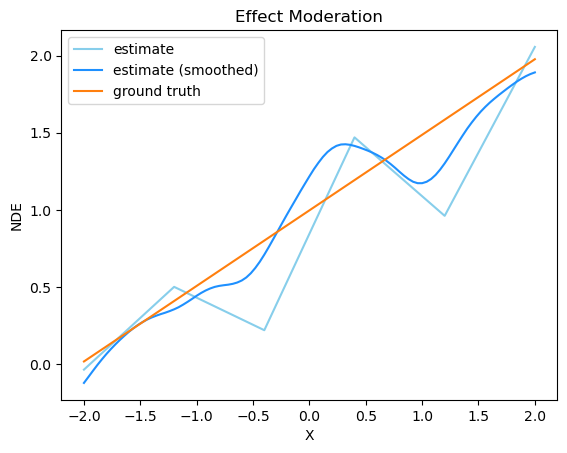

In [7]:
X = ContinuousVariable()
Y = ContinuousVariable()
M = ContinuousVariable()

env = Environment(exogenous_noise = {
    X : lambda rng, N : 2.0 * rng.standard_normal(N),    
    M : lambda rng, N : rng.standard_normal(N),
    Y : lambda rng, N : rng.standard_normal(N)
}, N=1000, seed=123)
model = Model(sem = {
    X : lambda value : value[X.Noise()],
    M : lambda value : 0.7 * value[X] + value[M.Noise()],
    Y : lambda value : (1.0 + 0.7 * value[M]) * value[X] + value[Y.Noise()]
})

fit_setup = mediation.FitSetup()
#ensemble = toy_setup.Ensemble(shared_setup=env, payloads=[ComputeNDE, ComputeGroundTruth01], runs=1000)

world = World(env, model)
estimator = mediation.NaturalEffects_StandardMediationSetup(fit_setup, source=X, target=Y, mediator=M,
                                                data=world.Observables())

grid = np.arange(-2.0, 2.8, 0.8)
nde_fct_est = estimator.NDE_grid(grid, normalize_by_delta=True)
x_values, nde_fct_est_smoothed = estimator.NDE_smoothed(-2.0, 2.0, normalize_by_delta=True, cf_delta=0.8)
nde_fct_ground_truth = toy_setup.GroundTruth_NDE_fct(X, Y, M, env, model, grid, normalize_by_delta=True, cf_delta=0.8)

plt.plot(np.arange(-2.0, 2.8, 0.8), nde_fct_est, color="skyblue", label="estimate")
plt.plot(x_values, nde_fct_est_smoothed, color="dodgerblue", label="estimate (smoothed)")
plt.plot(np.arange(-2.0, 2.8, 0.8), nde_fct_ground_truth, color="tab:orange", label="ground truth")
plt.legend()
plt.title(f"Effect Moderation")
plt.xlabel("X")
plt.ylabel("NDE")
#plt.savefig("Example1.pdf", format="pdf")
plt.show()

# Example 2: Effect on categorical Variables as shift in distribution<a id='ex2'></a>

Intervening on the value of X really is not just a change in expectation value, but in distribution.
Thus so are effects.
We illustrate this for the effect on a catgorical outcome Y with 3 categories.

The distribution over the three categories in the output is fully described by three numbers:
The probabilities for the occurence of each respective category:
[$p_0$, $p_1$, $p_2$].
The NDE is thus expressed as the expected change in these probabilites, when changing the value of X
while keeping M as if X had taken the original values.
These *shifts* in the individual probabilities can of course be negative, actually, since
$1 = p_0 + p_1 + p_2$, both before and after chaning X, the shifts should add up to 0.

In the example below "higher" categories are more likely for higher X. For small values of X, Y is likely to be in category 0 or 1, thus the effect of changing X,
while X is small, mostly consists of shifting occurences of category 0 to occurences of 1.
Thus the $p_0$ "loses" while $p_1$ "gains" in value.

Then for larger x occurences of category 1 shift to category 2. Additionally at some point $p_0$ is already close to $0$ and there is not much left to shift to category 1 from here. Hence category 1 "passes along" events to category 2 while not "receiving" new ones from category 0 anymore. As a result, now $p_1$ starts to drop,
while $p_2$ increases.

At some point (for very small or very large x), there is not much changing anymore: Basically all events occur in category 0 or 2 respectively. See also the next example 3.

All of this behavior is qualitatively very well represented by the results.

Note: The ground truth here looks more "noisy" than the estimate. This is because the estimate is smoothed over many estimates along the x-axis, while the ground-truth is "honest" with respect to noise in the system: It really computes the counterfactual world (for the 1000 sample points of noise given), which *is* noisy.

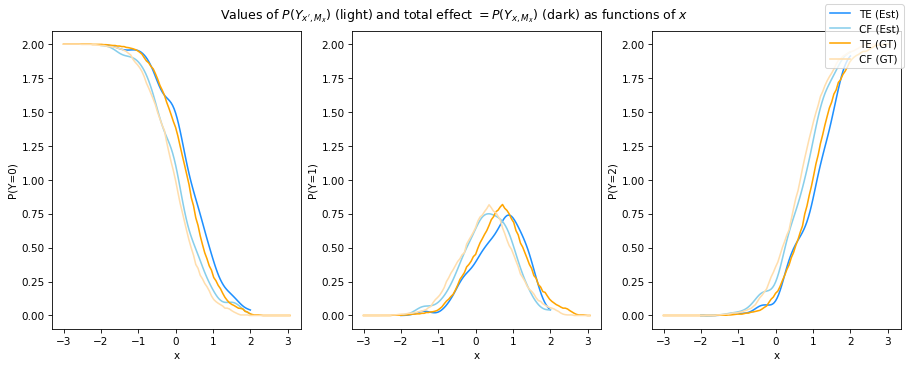

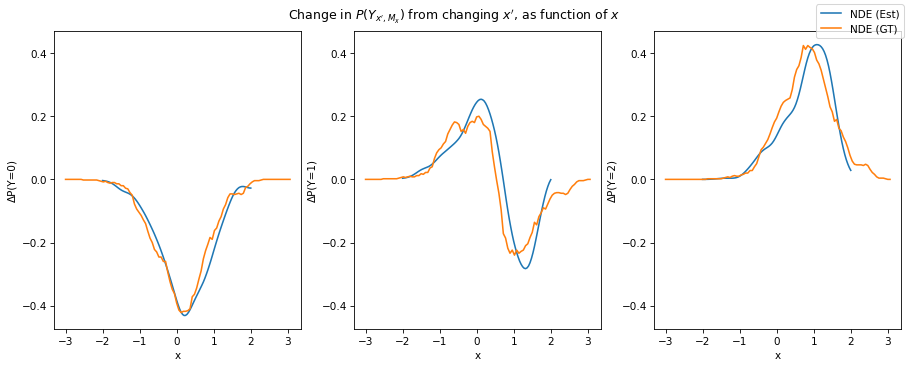

In [8]:
X = ContinuousVariable()
Y = CategoricalVariable(categories=3)
M = ContinuousVariable()

env = Environment(exogenous_noise = {
    X : lambda rng, N : 2.0 * rng.standard_normal(N),    
    M : lambda rng, N : rng.standard_normal(N),
    Y : lambda rng, N : rng.standard_normal(N)
}, N=1000, seed=12345)
model = Model(sem = {
    X : lambda value : value[X.Noise()],
    M : lambda value : 0.5 * value[X] + value[M.Noise()],
    Y : lambda value : np.round( np.clip(
            0.2 * value[Y.Noise()] + value[X] + value[M],
        a_min=-0.49, a_max=2.49 ) )
})

world = World(env, model)

fit_setup = mediation.FitSetup()
estimator = mediation.NaturalEffects_StandardMediationSetup(fit_setup, source=X, target=Y, mediator=M,
                                                    data=world.Observables())


x_smoothed, nde_fct_est_smoothed = estimator.NDE_smoothed(-2.0, 2.0, normalize_by_delta=True, steps=100)
grid = np.arange(-3.0, 3.06, 0.06)
nde_fct_ground_truth = toy_setup.GroundTruth_NDE_fct(X, Y, M, env, model, grid, normalize_by_delta=True)

plt_info_est = PlotInfo(color="tab:blue", label="NDE (Est)", colorTE="dodgerblue", colorCF="skyblue",
                        labelTE="TE (Est)", labelCF="CF (Est)")
plt_info_gt = PlotInfo(color="tab:orange", label="NDE (GT)", colorTE="orange", colorCF="navajowhite",
                       labelTE="TE (GT)", labelCF="CF (GT)")

plt_data_est = PlotInfo(x=x_smoothed, y=nde_fct_est_smoothed, **plt_info_est)
plt_data_gt = PlotInfo(x=grid, y=nde_fct_ground_truth, **plt_info_gt)

fig = toy_setup.PlotAbsProbabilities(plt, Y, [plt_data_est, plt_data_gt],
                labels=PlotInfo(x="x", y="P(Y={cY})",
                title=r"Values of $P(Y_{x',M_x})$ (light) and total effect $= P(Y_{x,M_x})$ (dark) as functions of $x$"))

fig = toy_setup.PlotChangeInProbabilities(plt, Y, [plt_data_est, plt_data_gt],
                labels=PlotInfo(x="x", y="ΔP(Y={cY})",
                title=r"Change in $P(Y_{x', M_x})$ from changing $x'$, as function of $x$"))


#plt.savefig("Example2.pdf", format="pdf")
plt.show()

# Example 3: Saturation of Pathways passing through Categorical Variables <a id='ex3'></a>

Here we look at the *indirect* effect, i.e. the effect "passing through" the mediator M.
This illustrates, how categorical variables behave non-linearly even on average:
One might think, that an increase of X can change the odds of categories in M linearly, so that *expectations* for the outcome change approximately linear as well. This can indeed happen, as long as the probabilites of the differenent categories of M are sufficiently balanced. However, at some point (e.g. for large enough X), M will "always" be in the same category anyway, so that further changing X cannot change that pathway anymore.
This leads to saturation of pathways through categorical mediators.

The noise in this example is chosen to be $\gamma$-distributed, mostly because otherwise the ground-truth would be a Gauß-curve, and using Gauß-smoothing on estimates seemed somewhat dubious for that case.
This means noise-values are non-negative.

Here, $M$ is simply given as follows: If $X + \eta_M > 1$ (where $\eta_M$ is the non-negative noise on $M$),
then $M=1$, otherwise $M=0$. Thus higher values of $X$ increase the odds of $M=1$ as compared to $M=0$.

For small values of $X$, $M$ is still well below the threshold (relative to the 'typical' noise on $M$),
hence $X + \eta_M$ is typically "small" compared to 1, and $P(X + \eta_M > 1)$ is small.

Approaching $X=1$, due to non-negativity of the noise on M, $P(X + \eta_M > 1)$ approaches one.

Beyond, $X>1$, always $P(X + \eta_M > 1)$, so moving $M$ further away from the threshold does not change the already saturated M any more.

Note: Smoothing the estimate more captures the qualitative form better, but also smooths out sharp features of the actual (ground-truth) result: For example the point in $X$ where the indirect effect approaches zero is gets biased away from the ground-truth value ($X=1$, see above).

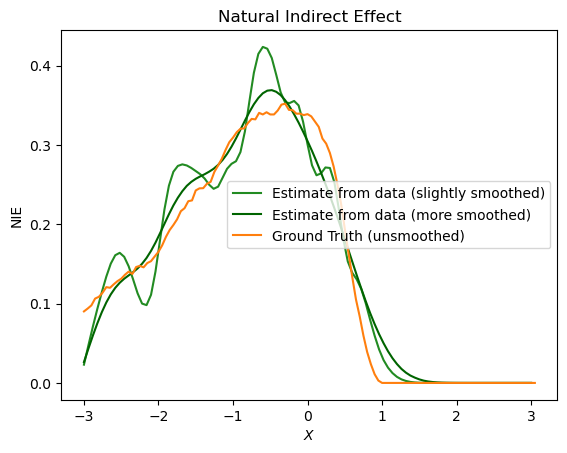

In [9]:
X = ContinuousVariable()
Y = ContinuousVariable()
M = CategoricalVariable(categories=2)

env = Environment(exogenous_noise = {
    X : lambda rng, N : 2.0 * rng.standard_gamma(2.0,size=N)-3.0,    
    M : lambda rng, N : rng.standard_gamma(2.0,size=N),
    Y : lambda rng, N : rng.standard_normal(N)
}, N=10000, seed=42 )
model = Model(sem = {
    X : lambda value : value[X.Noise()],
    M : lambda value : value[X] + value[M.Noise()] > 1.0, # M is binary, ie true or false
    Y : lambda value : value[X] + value[M] + value[Y.Noise()]
})
                  
world = World(env, model)

fit_setup = mediation.FitSetup()

estimator = mediation.NaturalEffects_StandardMediationSetup(fit_setup, source=X, target=Y, mediator=M,
                                                    data=world.Observables())

grid = np.arange(-3.0, 3.10, 0.05)
x_values2, nie_est_smoothed2 = estimator.NIE_smoothed(-3.0, 3.0, steps=100, smoothing_gaussian_sigma_in_steps=2,
                                                      normalize_by_delta=True)
x_values5, nie_est_smoothed5 = estimator.NIE_smoothed(-3.0, 3.0, steps=100, smoothing_gaussian_sigma_in_steps=5,
                                                      normalize_by_delta=True)
nie_ground_truth = toy_setup.GroundTruth_NIE_fct(X, Y, M, env, model, grid, normalize_by_delta=True)

plt.plot(x_values2, nie_est_smoothed2, color="forestgreen",
         label="Estimate from data (slightly smoothed)")
plt.plot(x_values5, nie_est_smoothed5, color="darkgreen",
         label="Estimate from data (more smoothed)")
plt.plot(grid, nie_ground_truth, color="tab:orange",
         label="Ground Truth (unsmoothed)")
plt.legend()
plt.xlabel(r"$X$")
plt.ylabel(r"NIE")
plt.title("Natural Indirect Effect")
#plt.savefig("Example3.pdf", format="pdf")
plt.show()

# Example 4: (Time-Series) Graphs - Feedback Loops <a id='ex4'></a>
Effect mediation in more complex graphs, e.g. in time-series graphs, is especially interessting. It requires adjustment-sets, which *if they exist*, can automatically be found and used by the implementation.
However, this makes fits more challenging and may not be possible for arbitrary effects in generic graphs.

The example below generates a time-series for a feed-back loop system. For example think of the (continuous) X as the temperature, and the (binary) M indicating the presence of a snow-cover. These (over time) are known to affect each other in a reinforcing way.
The natrual direct effect estimated here is the effect of temperature on future temperature (i.e. its "inertness") as opposed to the feedback through (albedo change) due to snow.

The Ground-Truth Graph (type is 'stationary_dag')
As a summary-graph:


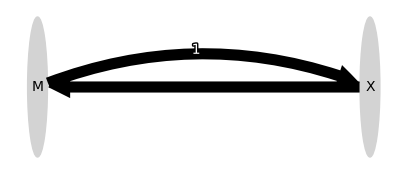

As a time series-graph:


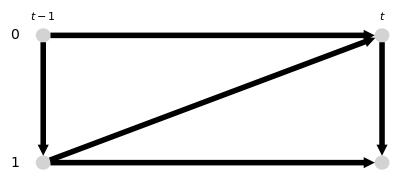


Automatically setting up an estimator
Estimator for the effect of X at lag 1 on X
Blocked Mediators:
 - M at lag 1
Adjustment Set:
 - M at lag 2

Manually setting up an estimator
Estimator for the effect of X at lag 1 on X
Blocked Mediators:
 - M at lag 1
Adjustment Set:
 - M at lag 2

Estimated NDE at x=0 is 0.670 (auto) = 0.670 (manual), analytical NDE is 0.800.
[Numerical Ground-Truth is 0.800]


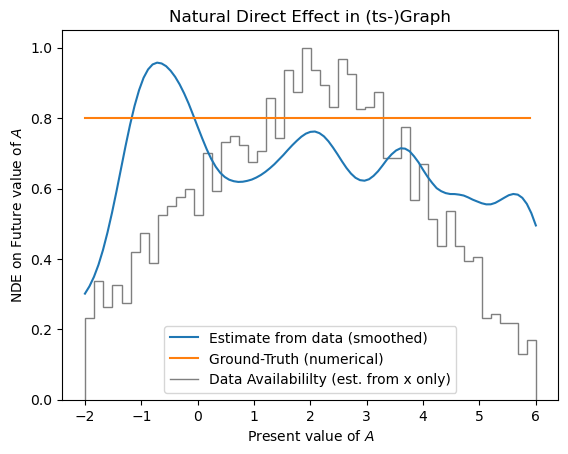

In [10]:
# The Model

X = toy_setup.ContinuousVariable("X")
M = toy_setup.CategoricalVariable("M", categories=2)
coeff = 0.8

env = toy_setup.Environment(exogenous_noise={
    X: lambda rng, N: 1.0 * rng.standard_normal(N),
    M: lambda rng, N: 1.0 * rng.standard_normal(N),
}, N=5000, seed=11)
model = toy_setup.Model(sem={
    X: lambda value: value[X.Noise()] + 0.5 * value[M.Lag(1)] + coeff * value[X.Lag(1)],
    M: lambda value: value[X] + value[M.Noise()] + 0.7 * value[M.Lag(1)] > 1.0  # M is binary, ie true or false
})

# The Groundtruth Graph
graph, graph_type = model.GetGroundtruthGraph()

print(f"The Ground-Truth Graph (type is '{graph_type}')")
print("As a summary-graph:")
tp.plot_graph(graph = graph,
        figsize = (5, 2),
        var_names = ["X", "M"]
        ); plt.show()

print("As a time series-graph:")
tp.plot_time_series_graph(graph = graph,
        figsize = (5, 2),
        ); plt.show()

# Generate data
world = toy_setup.World(env, model)
obs = world.Observables()

# Fit & Estimator Setup
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))
tau_max = 2

print("\nAutomatically setting up an estimator")
estimator = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X.Lag(1), effect_target=X,
                                                  blocked_mediators="all", adjustment_set="auto")
estimator.PrintInfo()

print("\nManually setting up an estimator")
estimator2 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                   effect_source=X.Lag(1), effect_target=X,
                                                   blocked_mediators=[M.Lag(1)], adjustment_set=[M.Lag(2)])
estimator2.PrintInfo()
print("")


# Compute Single-Value Estimates
nde01 = estimator.NDE(0.0, 1.0)
nde01_ = estimator2.NDE(0.0, 1.0)
nde01_gt = toy_setup.GroundTruth_NDE(0.0, 1.0, X.Lag(1), X, [M.Lag(1)], env, model)
print( f"Estimated NDE at x=0 is {nde01:.3f} (auto) = {nde01_:.3f} (manual), analytical NDE is {coeff:.3f}.")
print( f"[Numerical Ground-Truth is {nde01_gt:.3f}]")


# Compute Function-Estimates
x_min = -2.0
x_max = 6.0
x_values, nde_est_smoothed = estimator.NDE_smoothed(x_min, x_max, normalize_by_delta=True, cf_delta=.5,
                                                   smoothing_gaussian_sigma_in_steps=5)


x_values_gt, nde_fct_gt = toy_setup.GroundTruth_NDE_fct_auto(x_min, x_max, estimator, env, model,
                                            cf_delta=.5, normalize_by_delta=True)


# Plot Function-Estimates

plt.plot(x_values, nde_est_smoothed, color="tab:blue",
         label="Estimate from data (smoothed)")
plt.plot(x_values_gt, nde_fct_gt, color="tab:orange",
         label="Ground-Truth (numerical)")

plt.title("Natural Direct Effect in (ts-)Graph")
plt.xlabel(r"Present value of $A$")
plt.ylabel(r"NDE on Future value of $A$")

# (also show where we actually have data)
x = obs[X]
counts, bins = np.histogram(x[np.logical_and(x > x_min, x < x_max)], 50)
max_counts = np.max(counts)
plt.stairs(counts/max_counts, bins, color='tab:gray', label="Data Availabililty (est. from x only)")
plt.legend()
plt.show()

# Example 5: Exploring a more Complicated Model <a id='ex5'></a>
We set up a simple model (for illustrating the use of mediation methods, this is not supposed to be scientifically meaningful), that describes how "(non-)cloudedness" $X$ causes both higher temperature $M_1$ and higher likelihood of droughts $M_2$, which in turn both affect (via a reinforcing interaction) the wild-fire-risc $Y$.

Additionally temperature $M_1$ is assumed to also affect the occurences of droughts $M_2$. To make things more interessting, this effect is chosen, such that a drought is "guaranteed" to occur above a certain temperature-threshold.

The different pathways are not balanced, i.e. some are more important than others (see below).

## 1. Set up the model

Categorical variables are not only often intuitive, they also often perform better numerically (both in terms of computation speed and precision). Further, e.g. when (ML) preprocessing is used, having mixed-type (continuous and categorical variables) can be unavoidable.

### 1.1 Variables and SEM

In [11]:
# Variables
X = toy_setup.CategoricalVariable("Clouded", categories=2)
M1 = toy_setup.ContinuousVariable("Temperature")
M2 = toy_setup.CategoricalVariable("Drought", categories=2)
Y = toy_setup.CategoricalVariable("Wild-Fire", categories=2)

# The Model
autocorr = 0.3
temp_cutoff = .5
model = toy_setup.Model(sem={
    X: lambda value:
        autocorr * value[X.Lag(1)] + value[X.Noise()] > 0.5,
    M1: lambda value:
        autocorr * value[M1.Lag(1)] + (2.0 * value[X.Lag(1)] - 1.0) + value[M1.Noise()],
    M2: lambda value:
        np.square(autocorr * value[M2.Lag(1)] + value[X.Lag(1)] + value[M2.Noise()])
        > (temp_cutoff - value[M1.Lag(1)]),
    Y: lambda value:
        np.logical_or( autocorr * value[Y.Lag(1)] + value[M1.Lag(1)] + value[Y.Noise()] > 2.5,
            np.logical_and( value[M2.Lag(1)],
                autocorr * value[Y.Lag(1)] + 5.0 * (value[M1.Lag(1)]+0.5) + value[Y.Noise()] > 2.5 ) )
})

### 1.2 Generate Data

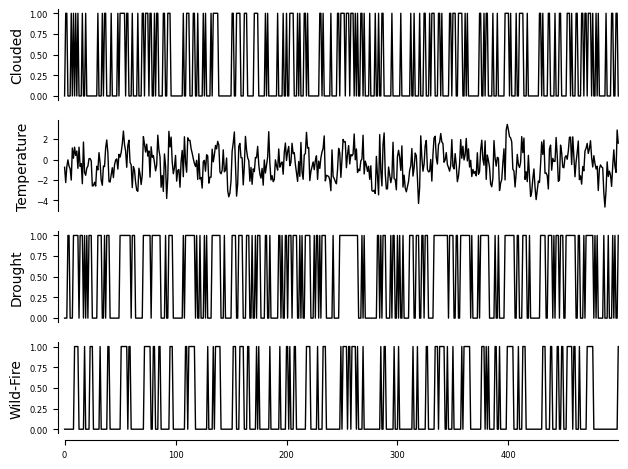

In [12]:
# Unobserved, exogenous noise (environment)
env = toy_setup.Environment(exogenous_noise={
    X: lambda rng, N: 1.0 * rng.standard_normal(N),
    M1: lambda rng, N: 1.0 * rng.standard_normal(N),
    M2: lambda rng, N: 1.0 * rng.standard_normal(N),
    Y: lambda rng, N: 1.0 * rng.standard_normal(N)
}, N=500, seed=11)

# The "world" to observe data from
world = toy_setup.World(env, model)
obs = world.Observables()

# The "dataframe" for use with tigramite
dataframe = toy_setup.DataframeFromVariables(obs)

#Plot the data
tp.plot_timeseries(dataframe); plt.show()

## 2. The Graph

### 2.1 Ground-Truth

Note, that the ground-truth generation does not validate "faithfullness", e.g. setting autocorr=0 will still produce auto-lags in the graph.

The ground truth graph (type=stationary_dag):
Summary Graph:


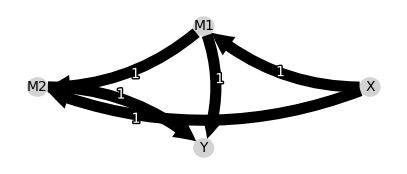

Time series graph:


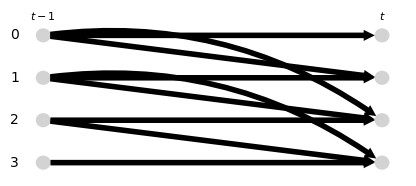

In [13]:
# Get from model
graph, graph_type = model.GetGroundtruthGraph()

print(f"The ground truth graph (type={graph_type}):")

# Plot summary graph
print("Summary Graph:")
tp.plot_graph(graph=graph,
        figsize = (5, 2),
        var_names = ["X", "M1", "M2", "Y"]
        ); plt.show()

# Plot Time series graph
print("Time series graph:")
tp.plot_time_series_graph(graph=graph,
        figsize = (5, 2),
        ); plt.show()

### 2.2 From Data via Causal Discovery

In [14]:
from tigramite.pcmci import PCMCI
# from tigramite.independence_tests.cmiknnmixed import CMIknnMixed
from tigramite.independence_tests.regressionCI import RegressionCI

#### (a) Using "regression CI"

Graph found with RegressionCI is:
Summary Graph:


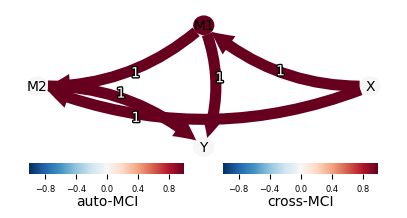

Time series graph:


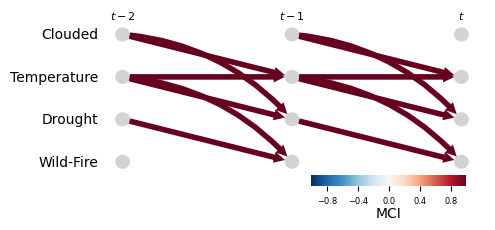

In [15]:
indep_test = RegressionCI()
tau_max = 2
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=indep_test)
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.1, alpha_level=0.01)
graph_cd = results['graph']


print("Graph found with RegressionCI is:")
# Plot summary graph
print("Summary Graph:")
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    figsize = (5, 2),
    var_names=["X", "M1", "M2", "Y"],
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

# Plot Time series graph
print("Time series graph:")
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    figsize = (5, 2),
    var_names=dataframe.var_names #["X", "M1", "M2", "Y"]
    ); plt.show()

#### (b) Using "CMIknnMixed"
(This is not currently available in the default/"master" branch)

In [16]:
# # Use fewer data-points, because this test tends to be slow

# # Unobserved, exogenous noise (environment)
# env.ResetWithNewSeed(new_seed=11, N=5000)

# # The "world" to observe data from
# world = toy_setup.World(env, model)
# obs = world.Observables()

# # The "dataframe" for use with tigramite
# dataframe = toy_setup.DataframeFromVariables(obs)

# indep_test = CMIknnMixed(significance='shuffle_test', sig_samples=50) # (you should use more than 50 ...)
# tau_max = 2
# pcmci = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=indep_test)
# results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.1, alpha_level=0.01)
# graph_cd = results['graph']


# print(f"Graph found with CMIknnMixed is:")
# # Plot summary graph
# print("Summary Graph:")
# tp.plot_graph(
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     figsize = (5, 2),
#     var_names=["X", "M1", "M2", "Y"],
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     show_autodependency_lags=False
#     ); plt.show()

# # Plot Time series graph
# print("Time series graph:")
# tp.plot_time_series_graph(
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     figsize = (5, 2),
#     var_names=["X", "M1", "M2", "Y"]
#     ); plt.show()

Not quite the ground-truth graph, but the assigned importance of links agrees very well with the mediation-results (see 3.3e), in particular all "important" links are found and all links that are found with large confidence are actually in the model (and important).

In [17]:
# For copy-paste without rerunning
print(results['graph'])
print(results['val_matrix'])

[[['' '' '']
  ['' '-->' '']
  ['' '-->' '']
  ['' '' '']]

 [['' '' '']
  ['' '-->' '']
  ['' '-->' '']
  ['' '-->' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '-->' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]]
[[[ 0.00000000e+00  6.01092727e+00  2.43836339e-02]
  [ 1.78987340e+00  3.18224615e+02  2.53111968e-03]
  [ 3.28257668e+00  3.09154177e+01  3.97064585e-01]
  [ 2.19677222e-01  7.35516531e-01  7.78482800e-02]]

 [[ 1.78987340e+00  6.09000838e-01  1.22202763e+00]
  [ 0.00000000e+00  4.60014854e+01  4.05340945e-03]
  [ 1.49385854e+00  1.15394487e+02  2.48657821e-01]
  [ 1.21518336e-01  1.31341974e+02  2.33024249e+00]]

 [[ 3.28257668e+00  5.91009912e+00  1.87256065e-01]
  [ 1.49385854e+00  1.02875792e+00  1.11868918e+00]
  [ 0.00000000e+00  4.63017596e-01  1.74021616e+00]
  [ 2.40872213e+00  1.21784838e+02  1.08953587e-01]]

 [[ 2.19677222e-01  1.96182605e+00  7.99065343e-02]
  [ 1.21518336e-01  8.64062333e-02  3.75142340e-01]
  [ 2.40872213e+00  3.03457802e-

## 3. Mediation Analysis

In [18]:
# Increase the number of data-points

# Unobserved, exogenous noise (environment)
env.ResetWithNewSeed(new_seed=11, N=5000)

# The "world" to observe data from
world = toy_setup.World(env, model)

### 3.1 Set up the fits

In [19]:
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))

### 3.2 Set up (an) Estimator

In [20]:
tau_max = 4
estimator = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X.Lag(2), effect_target=Y,
                                                  blocked_mediators="all", adjustment_set="auto")
    
estimator.PrintInfo()

Estimator for the effect of Clouded at lag 2 on Wild-Fire
Blocked Mediators:
 - Drought at lag 1
 - Temperature at lag 1
Adjustment Set:
 - Drought at lag 2
 - Wild-Fire at lag 1
 - Temperature at lag 2


### 3.3 Analyize the Effect of X on Y

#### (a) Both mediators blocked

In [21]:
# Compute the NDE of flipping X from 0 to 1
nde01 = estimator.NDE(False, True)

# Generate Ground-Truth from environment with (perfect) knowledge of the model
nde01_gt = toy_setup.GroundTruth_NDE(False, True, X.Lag(2), Y, [M1.Lag(1),M2.Lag(1)], env, model)
# We could also just copy the settings from the estimator:
nde01_gt_ = toy_setup.GroundTruth_NDE_auto(False, True, estimator, env, model)
assert np.all(nde01_gt == nde01_gt_)


print( f"Before change P(fire)={nde01[1][1]:.3f} [ground-truth: {nde01_gt[1][1]:.3f}].")
print( f"After change P(fire)={nde01[1][0]:.3f} [ground-truth: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased as a direct effect of X by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )
both_blocked = nde01[1][0] - nde01[1][1]
both_blocked_gt = nde01_gt[1][0] - nde01_gt[1][1]

Before change P(fire)=0.122 [ground-truth: 0.194].
After change P(fire)=0.137 [ground-truth: 0.194].
Thus fire-risc increased as a direct effect of X by 0.015 [gt: 0.000].



#### (b) Blocking only $M_1$ (temperature), resulting in drought-mediated effect only

In [22]:
# Set up an estimator for this effect
estimator2 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X.Lag(2), effect_target=Y,
                                                  blocked_mediators=[M1.Lag(1)], adjustment_set="auto")

nde01 = estimator2.NDE(0, 1) # Writing False/True or 0/1 should both work just fine 
nde01_gt = toy_setup.GroundTruth_NDE_auto(False, True, estimator2, env, model)
print( f"Before change P(fire)={nde01[1][1]:.3f} [ground-truth: {nde01_gt[1][1]:.3f}].")
print( f"After change P(fire)={nde01[1][0]:.3f} [ground-truth: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased as a direct+drought-induced effect of non-cloudiness by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )
M1_blocked = nde01[1][0] - nde01[1][1]
M1_blocked_gt = nde01_gt[1][0] - nde01_gt[1][1]

Before change P(fire)=0.121 [ground-truth: 0.194].
After change P(fire)=0.151 [ground-truth: 0.200].
Thus fire-risc increased as a direct+drought-induced effect of non-cloudiness by 0.030 [gt: 0.005].



Remark: The adjustment-set does not depend on which mediators are blocked:

In [23]:
estimator2.PrintInfo()

Estimator for the effect of Clouded at lag 2 on Wild-Fire
Blocked Mediators:
 - Temperature at lag 1
Adjustment Set:
 - Drought at lag 2
 - Wild-Fire at lag 1
 - Temperature at lag 2


#### (c) Blocking only $M_2$ resulting in the temperature-mediated effect only

In [24]:
estimator3 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                effect_source=X.Lag(2), effect_target=Y,
                                                blocked_mediators=[M2.Lag(1)], adjustment_set="auto")

nde01 = estimator3.NDE(0, 1) 
nde01_gt = toy_setup.GroundTruth_NDE_auto(False, True, estimator3, env, model)
print( f"Before change P(fire)={nde01[1][1]:.3f} [ground-truth: {nde01_gt[1][1]:.3f}]" )
print( f"After change P(fire)={nde01[1][0]:.3f} [gt: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased as a direct+temperature-induced effect of non-cloudiness by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )

M2_blocked = nde01[1][0] - nde01[1][1]
M2_blocked_gt = nde01_gt[1][0] - nde01_gt[1][1]

Before change P(fire)=0.122 [ground-truth: 0.194]
After change P(fire)=0.456 [gt: 0.475].
Thus fire-risc increased as a direct+temperature-induced effect of non-cloudiness by 0.334 [gt: 0.281].



#### (d) Blocking no mediators resulting in the total effect

In [25]:
# Set up an estimator for this effect    
estimator4 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X.Lag(2), effect_target=Y,
                                                  blocked_mediators=[], adjustment_set="auto",
# Flag for fallback (avoid warning):
                                                  fall_back_to_total_effect=True)

nde01 = estimator4.NDE(False, True)
nde01_gt = toy_setup.GroundTruth_NDE_auto(False, True, estimator4, env, model)

print( f"Before change P(fire)={nde01[1][1]:.3f} [ground-truth: {nde01_gt[1][1]:.3f}]" )
print( f"After change P(fire)={nde01[1][0]:.3f} [ground-truth: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased in total (directly + drought + temperature + interactions) by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )

total_effect = nde01[1][0] - nde01[1][1]
total_effect_gt = nde01_gt[1][0] - nde01_gt[1][1]

Before change P(fire)=0.122 [ground-truth: 0.194]
After change P(fire)=0.549 [ground-truth: 0.546].
Thus fire-risc increased in total (directly + drought + temperature + interactions) by 0.427 [gt: 0.351].



#### (e) Results

In [26]:
print( "Overview (estimated)" )
print( f"Direct: {100.0*both_blocked:.1f}%" )
print( f"Via Drought: {100.0*M1_blocked:.1f}%" ) # via M2, ie M1 blocked
print( f"Via Temperature: {100.0*M2_blocked:.1f}%" )
print( f"With Interaction and Mediator->Mediator effects: {100.0*total_effect:.1f}%" )

print("")
print( "Overview (ground-truth)" )
print( f"Direct: {100.0*both_blocked_gt:.1f}%" )
print( f"Via Drought: {100.0*M1_blocked_gt:.1f}%" ) # via M2, ie M1 blocked
print( f"Via Temperature: {100.0*M2_blocked_gt:.1f}%" )
print( f"With Interaction and Mediator->Mediator effects: {100.0*total_effect_gt:.1f}%" )

Overview (estimated)
Direct: 1.5%
Via Drought: 3.0%
Via Temperature: 33.4%
With Interaction and Mediator->Mediator effects: 42.7%

Overview (ground-truth)
Direct: 0.0%
Via Drought: 0.5%
Via Temperature: 28.1%
With Interaction and Mediator->Mediator effects: 35.1%


So overall this would lead us to (correctly) conclude, that the important effects are through temperature and interaction.

Note: Estimation near 50% is usually better (as expected, because individual outcomes are less important, as there are already many 0s and many 1s)

### 3.4 Temperature-Effects
What about "sub" effects in the middle of the graph?

#### (a) Analyize the situation

Estimator for the effect of Temperature at lag 2 on Wild-Fire
Blocked Mediators:
 - Drought at lag 1
 - Wild-Fire at lag 1
 - Temperature at lag 1
Adjustment Set:
 - Drought at lag 2
 - Wild-Fire at lag 2
 - Clouded at lag 2
Analyize where data is available:


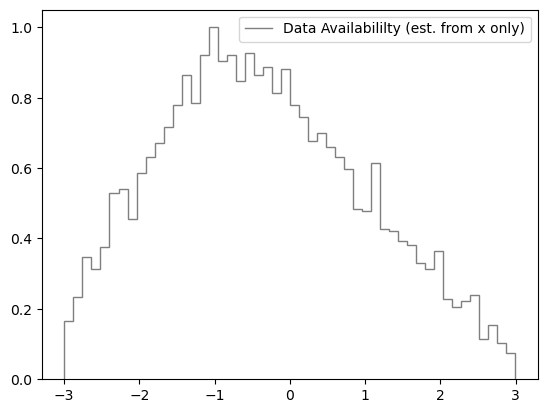

In [27]:
estimator5 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
# Note, that we are using a different source this time:
                                                  effect_source=M1.Lag(2), effect_target=Y,
                                                  blocked_mediators="all", adjustment_set="auto")

estimator5.PrintInfo()
    
print("Analyize where data is available:")
x = world.data[M1]
counts, bins = np.histogram(x[np.logical_and(x > -3.0, x < 3.0)], 50)
max_counts = np.max(counts)
plt.stairs(counts/max_counts, bins, color='tab:gray', label="Data Availabililty (est. from x only)")   
plt.legend()
plt.show()

In [28]:
# Pick some region where estimation seems reasonably supported by the data:
x_min = -2.0
x_max = 2.0

# Let's block the "boring ones" (source and target at different times)
blocked_mediators=[M1.Lag(1),Y.Lag(1)]

#### (b) Get an estimate of the NDE as function of the temperature

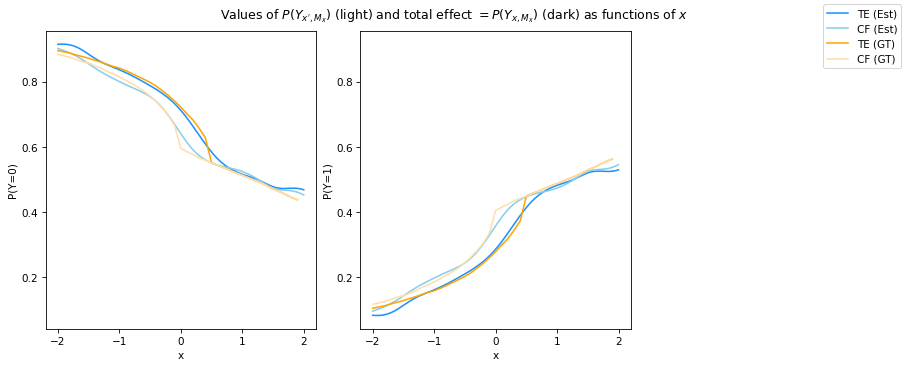

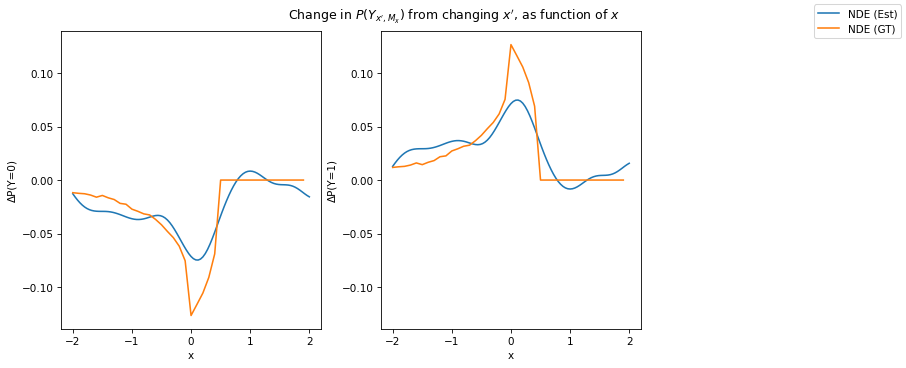

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013820>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013820>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013820>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013b80>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013b80>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013820>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013b80>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce3013820>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce33a64c0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce33a6ca0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce315f3a0>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ce16c0040>
Traceback (most recent call last):
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jakobrunge/anaconda3/envs/py39new/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

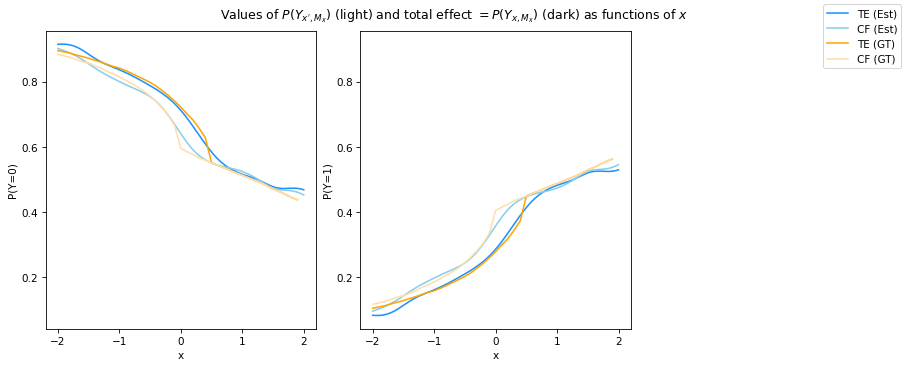

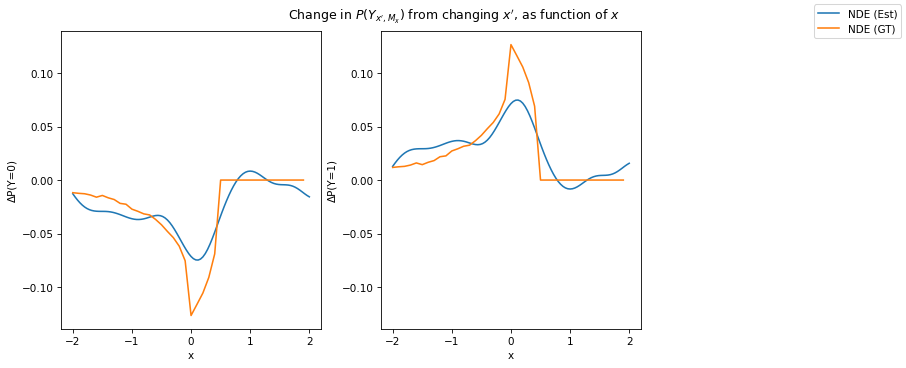

In [29]:
estimator5 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=M1.Lag(2), effect_target=Y,
                                                  blocked_mediators=blocked_mediators, adjustment_set="auto")
    
# Estimate function from data on [x_min, x_max], see above
x_values5, nde_est_smoothed5 = estimator5.NDE_smoothed(x_min, x_max, normalize_by_delta=False, cf_delta=.5,
                                                   smoothing_gaussian_sigma_in_steps=5, steps=100)

# Also generate the ground-truth to compare to
x_values_gt, nde_fct_ground_truth = toy_setup.GroundTruth_NDE_fct_auto(x_min, x_max, estimator5, env, model,
                                                   cf_delta=0.5, normalize_by_delta=False)

# Set up plots
plt_info_est = PlotInfo(color="tab:blue", label="NDE (Est)", colorTE="dodgerblue", colorCF="skyblue",
                        labelTE="TE (Est)", labelCF="CF (Est)")
plt_info_gt = PlotInfo(color="tab:orange", label="NDE (GT)", colorTE="orange", colorCF="navajowhite",
                       labelTE="TE (GT)", labelCF="CF (GT)")

plt_data_est = PlotInfo(x=x_values5, y=nde_est_smoothed5, **plt_info_est)
plt_data_gt = PlotInfo(x=x_values_gt, y=nde_fct_ground_truth, **plt_info_gt)

# Plot the results
fig = toy_setup.PlotAbsProbabilities(plt, Y, [plt_data_est, plt_data_gt],
                labels=PlotInfo(x="x", y="P(Y={cY})",
                title=r"Values of $P(Y_{x',M_x})$ (light) and total effect $= P(Y_{x,M_x})$ (dark) as functions of $x$"))

fig = toy_setup.PlotChangeInProbabilities(plt, Y, [plt_data_est, plt_data_gt],
                labels=PlotInfo(x="x", y="ΔP(Y={cY})",
                title=r"Change in $P(Y_{x', M_x})$ from changing $x'$, as function of $x$"))

plt.show()

#### (c) Results
After smoothing, "sharp" features of the ground-truth will obviously be lost, but the qualitative behavior is captured ok.

# Example 6: Unidentified Effects <a id='ex6'></a>
This example is similar to the one above, but not as a timeseries. This makes the graph simpler, but also removes some knowledge, so that not all effects are identifiable anymore.

Graph-Type is 'dag'


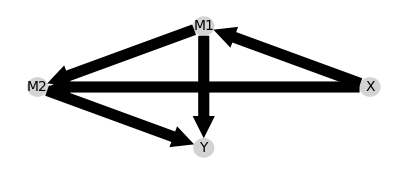

Estimated NDE (blocking both mediators) of changing X=Clouded x=False to x=True is:
Before change P(fire)=0.089 [gt: 0.087] and after change P(fire)=0.092  [gt: 0.087].
Thus fire-risc increased as a direct effect of non-cloudiness by 0.003 [gt: 0.000].

Estimated NDE (blocking only M1=temperature) of changing X=Clouded x=False to x=True is:
Before change P(fire)=0.087 [gt: 0.087] and after change P(fire)=0.142  [gt: 0.122].
Thus fire-risc increased as a direct+drought-induced effect of non-cloudiness by 0.055 [gt: 0.035].

While for blocking only M2=Drought ... (which is a 'kite'-graph / M1 is a 'recanting witness')
Got exception: The graph-effect you are trying to estimate is not identifiable via one-step adjustment, try using a different query or refine the causal graph by expert knowledge. For the implemented method, there must be an adjustment-set, valid for both X u M -> Y and X -> Y. If such a set exists, Perkovic's Adjust(X,Y) is valid, which was tried as fallback because adjust

In [30]:
X = toy_setup.CategoricalVariable("Clouded", categories=2)
M1 = toy_setup.ContinuousVariable("Temperature")
M2 = toy_setup.CategoricalVariable("Drought", categories=2)
Y = toy_setup.CategoricalVariable("Wild-Fire", categories=2)

env = toy_setup.Environment(exogenous_noise={
    X: lambda rng, N: 1.0 * rng.standard_normal(N),
    M1: lambda rng, N: 1.0 * rng.standard_normal(N),
    M2: lambda rng, N: 1.0 * rng.standard_normal(N),
    Y: lambda rng, N: 1.0 * rng.standard_normal(N)
}, N=5000, seed=11)
model = toy_setup.Model(sem={
    X: lambda value: value[X.Noise()] > 1.0,
    M1: lambda value: (value[X] + 1.0) * value[M1.Noise()],
    M2: lambda value: value[X] + value[M1] + value[M2.Noise()] > 1.0,
    Y: lambda value: np.logical_or( value[M1] + value[Y.Noise()] > 3.0,
                                   np.logical_and( value[M2], value[M1] + value[Y.Noise()] > 1.5 ) )
})

graph, graph_type = model.GetGroundtruthGraph()
graph = graph.reshape(graph.shape[0:2])

print(f"Graph-Type is '{graph_type}'")
tp.plot_graph(graph = graph,
        figsize = (5, 2),
        var_names = ["X", "M1", "M2", "Y"]
        ); plt.show()


world = toy_setup.World(env, model)


fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))
tau_max = 2
estimator = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X, effect_target=Y,
                                                  blocked_mediators="all", adjustment_set="auto")

nde01 = estimator.NDE(False, True)
nde01_gt = toy_setup.GroundTruth_NDE(False, True, X, Y, [M1,M2], env, model)
print( "Estimated NDE (blocking both mediators) of changing X=Clouded x=False to x=True is:" )
print( f"Before change P(fire)={nde01[1][1]:.3f} [gt: {nde01_gt[1][1]:.3f}] and after change P(fire)={nde01[1][0]:.3f}  [gt: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased as a direct effect of non-cloudiness by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )


estimator2 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X, effect_target=Y,
                                                  blocked_mediators=[M1], adjustment_set="auto")

nde01 = estimator2.NDE(0, 1) # Writing False/True or 0/1 should both work just fine ...
nde01_gt = toy_setup.GroundTruth_NDE(False, True, X, Y, [M1], env, model)
print( "Estimated NDE (blocking only M1=temperature) of changing X=Clouded x=False to x=True is:" )
print( f"Before change P(fire)={nde01[1][1]:.3f} [gt: {nde01_gt[1][1]:.3f}] and after change P(fire)={nde01[1][0]:.3f}  [gt: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased as a direct+drought-induced effect of non-cloudiness by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )

try:
    print( "While for blocking only M2=Drought ... (which is a 'kite'-graph / M1 is a 'recanting witness')" )
    estimator3 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                      effect_source=X, effect_target=Y,
                                                      blocked_mediators=[M2], adjustment_set="auto")
except Exception as e:
    print(f"Got exception: {e.args[0]}")
nde01_gt = toy_setup.GroundTruth_NDE(False, True, X, Y, [M2], env, model)
print(f"[Ground-Truth would have been: from {nde01_gt[1][1]:.3f} to {nde01_gt[1][0]:.3f}, difference {nde01_gt[1][0] - nde01_gt[1][1]:.3f}]]")
    
estimator4 = mediation.NaturalEffects_GraphMediation(graph, graph_type, tau_max, fit_setup, world.Observables(),
                                                  effect_source=X, effect_target=Y,
                                                  blocked_mediators=[], adjustment_set="auto",
                                                  fall_back_to_total_effect=True)

nde01 = estimator4.NDE(False, True)
nde01_gt = toy_setup.GroundTruth_NDE(False, True, X, Y, [], env, model)
print( "\nEstimated total-effect of changing X=Clouded x=False to x=True is:" )
print( f"Before change P(fire)={nde01[1][1]:.3f} [gt: {nde01_gt[1][1]:.3f}] and after change P(fire)={nde01[1][0]:.3f}  [gt: {nde01_gt[1][0]:.3f}]." )
print( f"Thus fire-risc increased in total (directly + drought + temperature + interactions) by {nde01[1][0] - nde01[1][1]:.3f} [gt: {nde01_gt[1][0] - nde01_gt[1][1]:.3f}].\n" )

# Technical Appendix: <a id='appendix'></a>

# Example A: Toymodels, Method Validation and Groundtruth <a id='exA'></a>
This example quickly demonstrates how we validate our methods and aims to give an impression of what accuracy and results to expect.
For models and effects of interest, see the examples below.

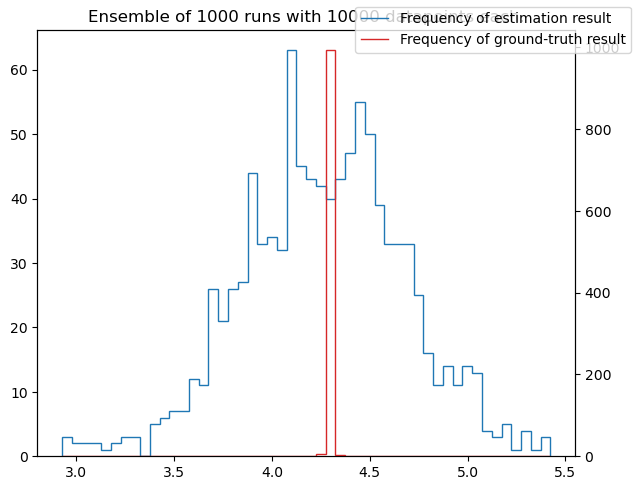

In [31]:
A = ContinuousVariable(name="Treatment")
M = CategoricalVariable(name="Mediator", categories=5)
Y = ContinuousVariable(name="Target")
env = Environment(exogenous_noise = {
    A : lambda rng, N : rng.standard_normal(N),    
    M : lambda rng, N : rng.binomial(M.categories-1,0.7,N),
    Y : lambda rng, N : rng.standard_normal(N)
}, N=10000)
model = Model(sem = {
    A : lambda value : value[A.Noise()],
    M : lambda value : np.clip( np.round( value[M.Noise()] + value[A] ).astype( dtype=np.dtype("int32") ), 0, M.categories-1 ),
    Y : lambda value : value[Y.Noise()] + 1.5 * value[A] + value[M] * value[A]
})

fit_setup = mediation.FitSetup()

def ComputeNDE(env):
    world = World(env,model)
    estimator = mediation.NaturalEffects_StandardMediationSetup(fit_setup, source=A, target=Y, mediator=M,
                                            data = world.Observables())
    return estimator.NDE(0.0,1.0)

model0 = model.Intervene(changes = { A : 0.0 })
model1 = model.Intervene(changes = { A : 1.0 })

def ComputeGroundTruth01(env):
    # This and similar functionality are also available in "toy_setup.py"
    world0 = toy_setup.World(env,model0)
    world1 = toy_setup.World(env,model1)
    cf_world = toy_setup.CounterfactualWorld(env,model)
    cf_world.TakeVariablesFromWorld(world0,[M])
    cf_world.TakeVariablesFromWorld(world1,[A])
    cf_world.Compute()    
    return np.mean(cf_world.data[Y] - world0.data[Y])

runs = 1000
ensemble = toy_setup.Ensemble(shared_setup=env, payloads=[ComputeNDE, ComputeGroundTruth01], runs=runs)

def PlotTestResults(results,bins=50):
    fig, ax1 = plt.subplots()
    counts, bins = np.histogram(results[0], bins)
    ax1.stairs(counts, bins, color='tab:blue', label="Frequency of estimation result")

    ax2 = ax1.twinx()
    counts, bins = np.histogram(results[1], bins)
    ax2.stairs(counts, bins, color='tab:red', label="Frequency of ground-truth result")

    fig.tight_layout()
    fig.legend()
    plt.title(f"Ensemble of {runs} runs with {env.N} datapoints each.")
    plt.show()
    
    
PlotTestResults(ensemble)

# Example B: Customize Fitting <a id='exB'></a>
The current implementation comes with customizable "fit-setups" for changing the behavior in "actual" (function-level) fits. Below are, in increasing complexity, extension-points that the current implementation provides.

A concrete example (handling missing values) is given below at [B.6](#fitModForMissing).

## B.1 The default setup
This is the easiest to use, it uses Sklearn's KNeighborsRegressor with 10 neighbors and uniform weigths for mappings and Sklearn's KernelDensity with gaussian kernel and bandwidth 0.2.

In [32]:
fit_setup = mediation.FitSetup()

## B.2 Default setup with custom parameters
Use the defaults, but with other parameters (or with GaussianProcessRegressor instead of KNeighborsRegressor)

In [33]:
fit_setup = mediation.FitSetup(
    fit_map = mediation.FitProvider_Continuous_Default.UseSklearn(neighbors=10, weights='uniform'),
    fit_density = mediation.FitProvider_Density_Default.UseSklearn(kernel='gaussian', bandwidth=0.2)
)

# or using KNeighborsRegressor (arguments passed to UseSklearn_GC(...) are forwarded to sklearn)
fit_setup = mediation.FitSetup(
    fit_map = mediation.FitProvider_Continuous_Default.UseSklearn_GC(),
    fit_density = mediation.FitProvider_Density_Default.UseSklearn(kernel='gaussian', bandwidth=0.2)
)

## B.3 Default setup with custom fits
Use the default setup, but provide any callable that given data (see B.4 below) returns an function-object f, that can be called via f(x) or f.predict(x) (see B.4 below).
Maps can be picked separately for one-dimensional fits (see B.4 below).

In [34]:
from sklearn.neighbors import KNeighborsRegressor, KernelDensity

fit_map = mediation.FitProvider_Continuous_Default(
    # e.g.:
    lambda x, y: KNeighborsRegressor(n_neighbors=10, weights='uniform').fit(x, y)
)
fit_map2 = mediation.FitProvider_Continuous_Default(
    # e.g.:
    lambda x, y: KNeighborsRegressor(n_neighbors=30, weights='uniform').fit(x, y),
    # 1d fits are different, could e.g. use splines instead
    fit_map_1d = 
    lambda x, y: KNeighborsRegressor(n_neighbors=5, weights='uniform').fit(x, y)
)

fit_density = mediation.FitProvider_Density_Default(
    # e.g. (but could also use normalizing flows etc)
    lambda x: KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x)
)

# or using KNeighborsRegressor (arguments passed to UseSklearn_GC(...) are forwarded to sklearn)
fit_setup = mediation.FitSetup(
    fit_map = fit_map,
    fit_density = fit_density
)

## B.4 Default Setup with Custom fit provider
The "fit providers" set up above can also be overwritten, the current implementation uses. A custom implementation has to provide the interface containing 'def Get_Fit_Continuous(x, y):', or 'Get_Fit_Density(x_train)', see below.

In [35]:
class FitProvider_Continuous_Default_Tutorial:
    def __init__(self, fit_map, fit_map_1d=None):
        self.fit_map = fit_map
        self.fit_map_1d = fit_map_1d

    @classmethod
    def UseSklearn(cls, neighbors=10):
        return cls(lambda x, y: KNeighborsRegressor(n_neighbors=neighbors, weights='uniform').fit(x, y))

    @classmethod
    def UseSklearn_GC(cls, neighbors=10):
        from sklearn.gaussian_process import GaussianProcessRegressor
        return cls(lambda x, y: GaussianProcessRegressor().fit(x, y))

    def Get_Fit_Continuous(self, x, y):
        dim_of_domain = np.shape(x)[1]
        if dim_of_domain == 0:
            return lambda x_dim_zero: np.mean(y)
        elif dim_of_domain == 1 and self.fit_map_1d is not None:
            return self.fit_map_1d(x, y)  # use splines?
        else:
            return self.fit_map(x, y)

In [36]:
class FitProvider_Density_Default_Tutorial:
    def __init__(self, fit_density):
        self.fit_density = fit_density

    @classmethod
    def UseSklearn(cls, kernel='gaussian', bandwidth=0.2):
        return cls(lambda x: KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(x))

    def Get_Fit_Density(self, x_train):
        dim_of_domain = np.shape(x_train)[1]
        if dim_of_domain == 0:
            return lambda x_dim_zero: np.ones(np.shape(x_dim_zero)[0])
        elif np.shape(x_train)[0] > 0:
            model = self.fit_density(x_train)
            return lambda x_predict: np.exp(model.score_samples(x_predict))
        else:
            return lambda x_predict: np.zeros(np.shape(x_predict)[0])

In [37]:
fit_setup = mediation.FitSetup(
    fit_map = FitProvider_Continuous_Default_Tutorial.UseSklearn(),
    fit_density = FitProvider_Density_Default_Tutorial.UseSklearn()
)

## B.5 Custom fit-setup
The current fit-setup implementation is based on transfer-matrices, and uses the two fit providers for maps and densities as outlined above, to extend this approach from categorical data to mixed data.

There are of course alternatives to this approach, for example one-hot-encoding, that come with their own advantages and disadvantages. Any such setup can be used with the mediation-analysis implementations above, it has to expose a .Fit as outline below (see also mediation.py -> FitSetup).

In [38]:
class FitSetup_Tutorial:
    def Fit(self, domain, target, dont_wrap_1d_y_in_vector=True):
        # domain is a dictionary { var-ids-domain : data } of the domain-variables
        # target is a dictionary { var-ids-target : data } of the target-variables
        # (var ids are toy_setup.CategoricalVariable or toy_setup.ContinuousVariable, check e.g. via var.is_categorical,
        #  and contain additional information about variables, e.g. var.categories or var.dimension, cf toy_setup.py)
        # dont_wrap_1d_y_in_vector indicates wheter to return scalar targets as scalars or 1d-vectors
        
        # return a function object f that can be called via
        # f({ var-ids-domain : data }) or via
        # f.predict({ var-ids-domain : data })
        # and returning [a python iterable with one entry per target Y (see dont_wrap_1d_y_in_vector)]
        # with entries np.arrays of shape:
        # [data-points in 'data', dimension of Y] if Y is continuous, containing expectations-values
        # [data-points in 'data', categories of Y] if Y is categorical, containing category-probabilities
        return None

## B.6 An actual example: Missing Values <a id='fitModForMissing'></a>

Handling missing values "just in time" can be more sample-efficient than using the built-in dataframe-preprocessing, because the dataframe uniformly requires all data to be valid for all fits, while deciding this "late" during the fit can be more efficient. Also this is a nice example to demonstrate how to use the extension-points for fitters.

First, we generate data as in Example 0 (b):

In [39]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
var_names = ['$X^0$', '$X^1$', '$X^2$']

In [40]:
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

coeff = .5
direct_eff = 0.5
def lin_f(x): return x
links_coeffs = {
                0: [((0, -1), coeff, lin_f), ((1, -1), coeff, lin_f)], 
                1: [((1, -1), coeff, lin_f),], 
                2: [((2, -1), coeff, lin_f), ((1, 0), coeff, lin_f), ((1,-2), direct_eff, lin_f)],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=98765)
normalization = []
data_normalized = np.empty_like(data)
for v in range(0,3):
    m = np.std(data[:,v])
    normalization.append(m)
    data_normalized[:,v] = data[:,v] / m

In [41]:
seed = 123456
gap_count = 20
gap_min_len = 10
gap_max_len = 20
missing_flag = 999
rng = np.random.default_rng(seed)
var_idx = rng.integers(0, data_normalized.shape[1], gap_count)
offset = rng.integers(0, data_normalized.shape[0]-gap_max_len, gap_count)
missing_count = rng.integers(10, 20, gap_count)

modified_data = data_normalized.copy()
for gap in range(gap_count):
    modified_data[offset[gap]:offset[gap]+missing_count[gap], var_idx] = missing_flag

dataframe_missing_data = pp.DataFrame(modified_data, var_names=var_names, missing_flag=missing_flag)

Using dataframe only:

In [42]:
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))

# normalized data
internal_estimator = causal_effects.fit_natural_direct_effect(dataframe_missing_data, blocked_mediators='all',
                                mixed_data_estimator=fit_setup,
                                enable_dataframe_based_preprocessing=True)

nde_est = causal_effects.predict_natural_direct_effect(0.0, 1.0) * normalization[2] / normalization[1]

# print results
print( f"Estimate of the NDE is:\n{nde_est} with missing values,\nground-truth is {direct_eff}." )

Estimate of the NDE is:
0.3910014033317566 with missing values,
ground-truth is 0.5.


In [43]:
number_of_datapoints_used_from_dataframe = internal_estimator.sources[internal_estimator.X].shape[0]
print(number_of_datapoints_used_from_dataframe)

730


With custom fitter:

In [44]:
class FitProvider_Continous_Filtered:
    def __init__(self, underlying_fit_provider, filter_to_use):
        self.filter = filter_to_use
        self.underlying_fit_provider = underlying_fit_provider
    def Get_Fit_Continuous(self,x_train,y_train):
        return self.underlying_fit_provider.Get_Fit_Continuous(*self.filter.apply(x_train,y_train))
    
class FitProvider_Density_Filtered:
    def __init__(self, underlying_fit_provider, filter_to_use):
        self.filter = filter_to_use
        self.underlying_fit_provider = underlying_fit_provider
    def Get_Fit_Density(self, x_train):
        return self.underlying_fit_provider.Get_Fit_Density(self.filter.apply(x_train))

class FilterMissingValues:
    def __init__(self, missing_value_flag):
        self.missing_value_flag = missing_value_flag
    def apply(self,x,y=None):
        missing_in_any_x = np.any( x==self.missing_value_flag, axis=1 )
        if y is None:
            valid = np.logical_not( missing_in_any_x )
            print(f"Data-points used for fit: {np.count_nonzero(valid)}")
            return x[valid]
        else:
            missing_in_y = ( y==self.missing_value_flag )
            valid = np.logical_not( np.logical_or(missing_in_any_x, missing_in_y) )
            print(f"Data-points used for fit: {np.count_nonzero(valid)}")
            return x[valid], y[valid]

def apply_filter_to_all_inputs(fit_setup, filter_to_apply):
    # Assume the fit_setup can be contructed from map & density fit and has corresponding members
    # (for all implementations based on the FitSetup class in the mediation-module
    #  of tigramite this is the case; see tutorial on mediation, appendix B)
    return fit_setup.__class__(
        fit_map=FitProvider_Continous_Filtered(fit_setup.fit_map, filter_to_apply),
        fit_density=FitProvider_Density_Filtered(fit_setup.fit_density, filter_to_apply),
    )

In [45]:
fit_setup = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))
fit_setup2 = apply_filter_to_all_inputs(fit_setup, FilterMissingValues(missing_flag))
dataframe_unmarked_missing = pp.DataFrame(modified_data, var_names=var_names) #missing_flag=999)


# normalized data
causal_effects.fit_natural_direct_effect(dataframe_unmarked_missing, blocked_mediators='all',
                                mixed_data_estimator=fit_setup2, # set the new fit_setup
                                enable_dataframe_based_preprocessing=False)

nde_est_custom = causal_effects.predict_natural_direct_effect(0.0, 1.0) * normalization[2] / normalization[1]

# print results
print( f"Estimate of the NDE is:\n{nde_est_custom} with custom fit, \nground-truth is {direct_eff}." )
print( f"Directly from dataframe had:\n{nde_est}." )
print(f"Via dataframe used {number_of_datapoints_used_from_dataframe} data-points for all fits")

Data-points used for fit: 730
Data-points used for fit: 756
Estimate of the NDE is:
0.3415490984916687 with custom fit, 
ground-truth is 0.5.
Directly from dataframe had:
0.3910014033317566.
Via dataframe used 730 data-points for all fits


# Example C: Inspecting Fits <a id='exC'></a>
From the code in nde.py, it is usually easy to see which fits actually get executed, these can be inspected e.g. via:
(see also Example 0 for possible issues, that might require data-normalization)

In [46]:
X = toy_setup.CategoricalVariable("Clouded", categories=2)
M1 = toy_setup.ContinuousVariable("Temperature")
M2 = toy_setup.CategoricalVariable("Drought", categories=2)
Y = toy_setup.CategoricalVariable("Wild-Fire", categories=2)

env = toy_setup.Environment(exogenous_noise={
    X: lambda rng, N: 1.0 * rng.standard_normal(N),
    M1: lambda rng, N: 1.0 * rng.standard_normal(N),
    M2: lambda rng, N: 1.0 * rng.standard_normal(N),
    Y: lambda rng, N: 1.0 * rng.standard_normal(N)
}, N=5000, seed=11)
autocorr = 0.3
model = toy_setup.Model(sem={
    X: lambda value: autocorr * value[X.Lag(1)] + value[X.Noise()] > 1.0,
    M1: lambda value: autocorr * value[M1.Lag(1)] + (2.0 * value[X.Lag(1)] - 1.0) + value[M1.Noise()],
    M2: lambda value: autocorr * value[M2.Lag(1)] + value[X.Lag(1)] + value[M1.Lag(1)] + value[M2.Noise()] > 1.5,
    Y: lambda value: np.logical_or(autocorr * value[Y.Lag(1)] + value[M1.Lag(1)] + value[Y.Noise()] > 2.5,
                                   np.logical_and(value[M2.Lag(1)],
                                                  autocorr * value[Y.Lag(1)] + 5.0 * value[M1.Lag(1)] + value[
                                                      Y.Noise()] > 2.5))
})


fit = mediation.FitSetup(mediation.FitProvider_Continuous_Default.UseSklearn(20))

# World for training data
world_train = toy_setup.World(env, model)

M1_past = toy_setup.ContinuousVariable("T_past")
M2_past = toy_setup.CategoricalVariable("D_past", categories=2)
Y_past = toy_setup.CategoricalVariable("F_past", categories=2)
obs = world_train.Observables()

# Do Fit
f = fit.Fit_CategoricalTarget_MarkovKernel({M1_past: obs[M1][0:-1],
                                             M2_past:   obs[M2][0:-1],
                                             Y_past:   obs[Y][0:-1]},
                                           obs[Y][1:], Y.categories)

# World for test data
env.ResetWithNewSeed(77)
world_test = toy_setup.World(env, model)
obs = world_test.Observables()


# Predict on test data
predictions = f({M1_past: obs[M1][0:-1], M2_past: obs[M2][0:-1], Y_past: obs[Y][0:-1]})
predictions_mean = np.mean(predictions, axis=0)

print("Predictions: " + str(predictions_mean))

# Compare to actual values
actual = np.zeros(Y.categories)
for cY in range(Y.categories):
    actual[cY] = np.count_nonzero(obs[Y] == cY) / env.N
print("Actual: " + str(actual))
err_abs_max = np.max(np.abs(predictions_mean - actual))
assert err_abs_max < 0.01, "Prediction did not agree with ground-truth " + str(np.abs(predictions_mean - actual))

Predictions: [0.95001178 0.04998822]
Actual: [0.9522 0.0478]


For example the default choice, using nearest neighbors, might perform poorly on data with "sharp" features, this can often be seen easily (one could of course also plot vs observations, rather than vs ground-truth)

Predictions: [0.03549237 0.178419   0.78608863]
Actual: [0.028 0.182 0.79 ]


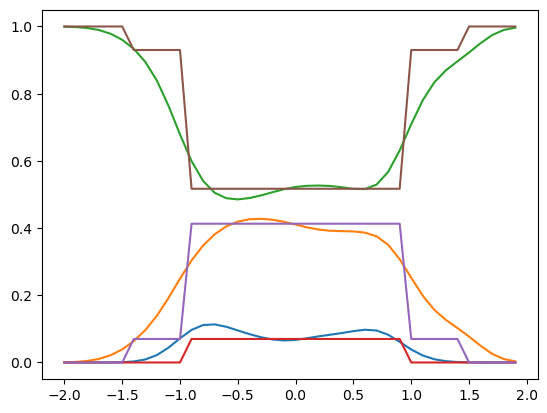

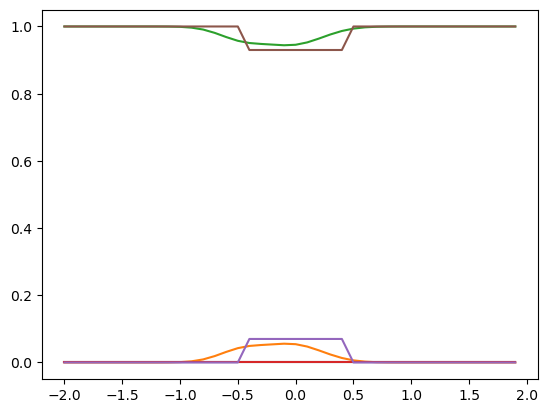

In [47]:
fit_setup = mediation.FitSetup()
X1 = toy_setup.CategoricalVariable(categories=2)
X2 = toy_setup.ContinuousVariable()
Y = toy_setup.CategoricalVariable(categories=3)
env = toy_setup.Environment(exogenous_noise={
    X1: lambda rng, N: rng.binomial(X1.categories - 1, 0.4, N),
    X2: lambda rng, N: rng.standard_normal(N),
    Y: lambda rng, N: rng.binomial(Y.categories - 1, 0.7, N),
}, N=1000, seed=55)
model = toy_setup.Model(sem={
    X1: lambda value: value[X1.Noise()],
    X2: lambda value: value[X2.Noise()],
    Y: lambda value: np.clip(value[Y.Noise()] + 1.75 * value[X1] + value[X2] * value[X2],
                             0, Y.categories-1).astype(dtype="int32")
})

world_train = toy_setup.World(env, model)
f = fit_setup.Fit({X1: world_train.data[X1], X2: world_train.data[X2]}, {Y: world_train.data[Y]})

env.ResetWithNewSeed(77)
world_test = toy_setup.World(env, model)
predictions = np.mean(f({X1: world_test.data[X1], X2: world_train.data[X2]}), axis=0)
print("Predictions: " + str(predictions))
actual = np.zeros(Y.categories)
for cY in range(Y.categories):
    actual[cY] = np.count_nonzero(world_test.data[Y] == cY) / env.N
print("Actual: " + str(actual))
err_abs_max = np.max(np.abs(predictions - actual))
assert err_abs_max < 0.01, "Prediction did not agree with ground-truth " + str(np.abs(predictions - actual))

# Note that noise on Y is binomial, so only discrete steps happen in the ground-truth
for cX in range(X1.categories):
    x2 = np.arange(-2.0, 2.0, 0.1)
    y = f({X1: np.full_like(x2, cX, dtype=np.dtype("uint32")), X2: x2})
    plt.plot(x2,y)
    noise = env.GetNoise()
    y_noise = noise[Y.Noise()]
    result = []
    for x2value in x2:
        y_values = model.SEM[Y](
            {X1: np.full_like(y_noise, cX, dtype=np.dtype("uint32")),
             X2: np.full_like(y_noise, x2value, dtype=np.dtype("float32")),
             Y.Noise(): y_noise
        })
        this_point_p = []
        for cY in range(Y.categories):
            this_point_p.append(np.count_nonzero(y_values == cY))
        result.append(this_point_p)
    plt.plot(x2, np.array(result)/env.N)
    plt.show()